# SMA Crossover Strategy (Hourly BTC)
This strategy demonstrates a simple trading strategy that uses
**Simple Moving Average (SMA) crossovers** to generate buy and sell signals.
 
#### Strategy Logic
- **Buy Entry (Golden Cross)**: When the 20-SMA crosses **above** the 50-SMA
- **Sell Exit (Death Cross)**: When the 20-SMA crosses **below** the 50-SMA
 
We'll apply this logic to hourly BTCUSDT data, using a simple backtesting framework and visualize the result.
### Before we begin, we load and process the data, and calculate the necessary indicators.


In [1]:
import pandas as pd
from overfitting import Strategy, Slippage

In [2]:
def load_data():
    df = pd.read_csv('./data/BTCUSDT.csv')
    benchamrk_df = pd.read_csv('./data/BTCUSDT.csv') # BTC buy and Hold
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    start_time = pd.to_datetime('2023-01-01 00:00:00')
    df = df.loc[start_time:]
    # Compute short and long SMAs
    df['sma_short'] = df['close'].rolling(window=20).mean().shift(1)
    df['sma_long'] = df['close'].rolling(window=50).mean().shift(1)

    return df, benchamrk_df

backtest_data, benchmark_data = load_data()
print(backtest_data.head())


                        open     high      low    close    volume  \
timestamp                                                           
2023-01-01 00:00:00  16537.5  16540.9  16504.0  16527.0  5381.399   
2023-01-01 01:00:00  16527.1  16554.3  16524.1  16550.4  3210.826   
2023-01-01 02:00:00  16550.5  16557.1  16534.8  16542.4  2399.668   
2023-01-01 03:00:00  16542.5  16542.5  16515.0  16529.3  3214.480   
2023-01-01 04:00:00  16529.2  16530.4  16508.8  16517.8  3150.954   

                        close_time  sma_short  sma_long  
timestamp                                                
2023-01-01 00:00:00  1672534799999        NaN       NaN  
2023-01-01 01:00:00  1672538399999        NaN       NaN  
2023-01-01 02:00:00  1672541999999        NaN       NaN  
2023-01-01 03:00:00  1672545599999        NaN       NaN  
2023-01-01 04:00:00  1672549199999        NaN       NaN  


## The Strategy Conditions

### Buy Entry (Golden Cross)
- When the 20-period SMA crosses **above** the 50-period SMA
- And there is **no existing position**

### Exit (Death Cross)
- When the 20-period SMA crosses **below** the 50-period SMA
- And a **long position is open**

### Now let's code the strategy logic

In [3]:
class MyStrategy(Strategy):
    def init(self):
        self.asset = 'BTC'
        self.set_leverage(self.asset, 1)

    def next(self, i):
        if i == 0:
            return

        sma_short = self.val(self.asset, i, "sma_short")
        sma_long = self.val(self.asset, i, "sma_long")
        previous_sma_short = self.val(self.asset, i - 1, "sma_short") 
        previous_sma_long = self.val(self.asset, i - 1, "sma_long")

        # Also skip if values are not available
        if (pd.isna(sma_short) or pd.isna(sma_long) or 
            pd.isna(previous_sma_short) or pd.isna(previous_sma_long)):
            return

        # Fetch the current position
        position = self.get_position(self.asset)

        # Golden cross (entry)
        if previous_sma_short <= previous_sma_long and sma_short > sma_long and position.qty == 0:
            # First fetch current open price which is the target Price
            open_price = self.open(self.asset, i)
            # Determine Lot Size
            lot_size = self.get_balance() // open_price
            # Create LIMIT ORDER
            self.limit_order(self.asset, lot_size, open_price)

        # Death cross (exit)
        if previous_sma_short >= previous_sma_long and sma_short < sma_long and position.qty > 0:
            self.market_order(self.asset, -position.qty)


### Let's run the strategy and plot the results.


Performance Summary
Number of Years               1.66000000
Start Date           2023-01-01 00:00:00
End Date             2024-08-29 00:00:00
Initial Balance         100,000.00000000
Final Balance           140,511.06866440
CAGR                          0.22734757
Cumulative Return             1.40511069
Sharpe Ratio                  0.70922509
Sortino Ratio                 1.83632508
Max Drawdown                 -0.29475190
Daily Value At Risk          -0.03973182
Skew                          0.46829326
Kurtosis                      2.94025840
Total Trades                182.00000000
Winning Trades               62.00000000
Losing Trades               120.00000000
Win Rate (%)                 34.06593407
Gross Profit            289,874.76385838
Gross Loss             -249,363.69519398
Net Profit               40,511.06866440
Avg Return (%)                0.18892109
Avg Profit (%)                3.74106259
Avg Loss (%)                 -1.64635202
  Net drawdown in %  Peak date Valley

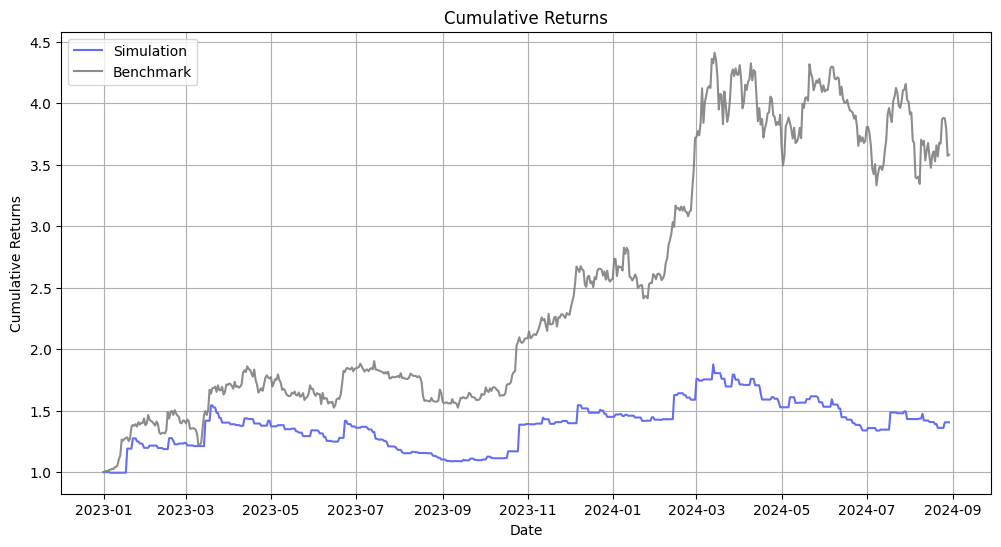

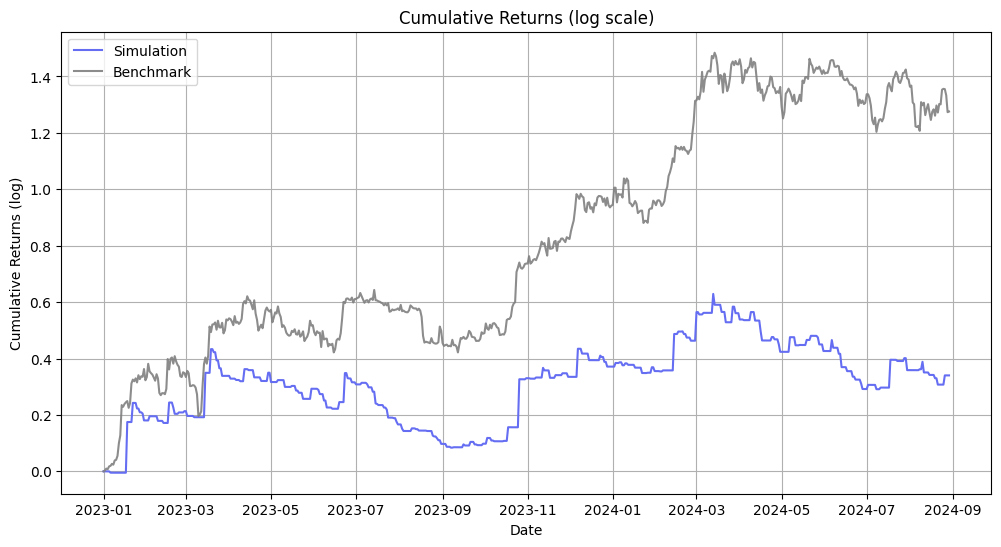

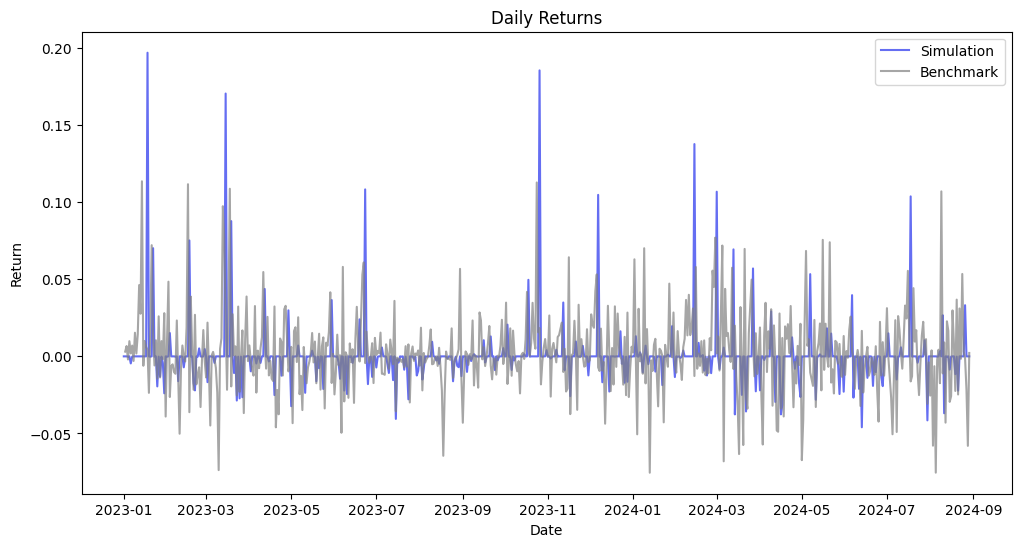

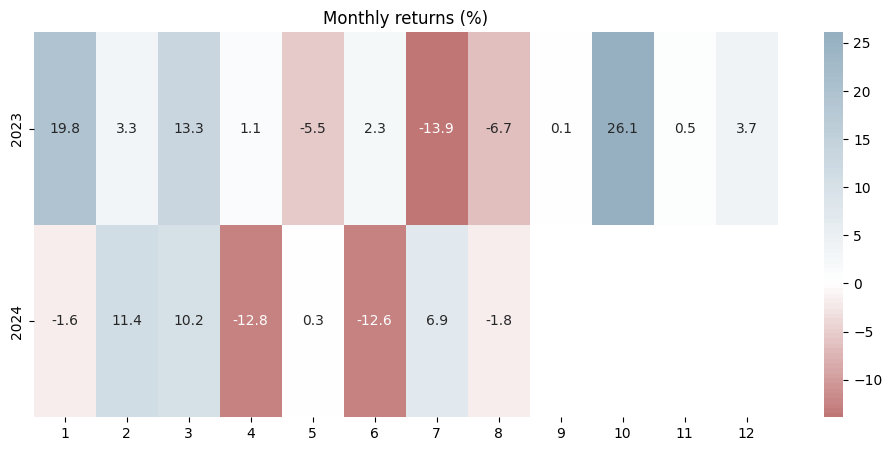

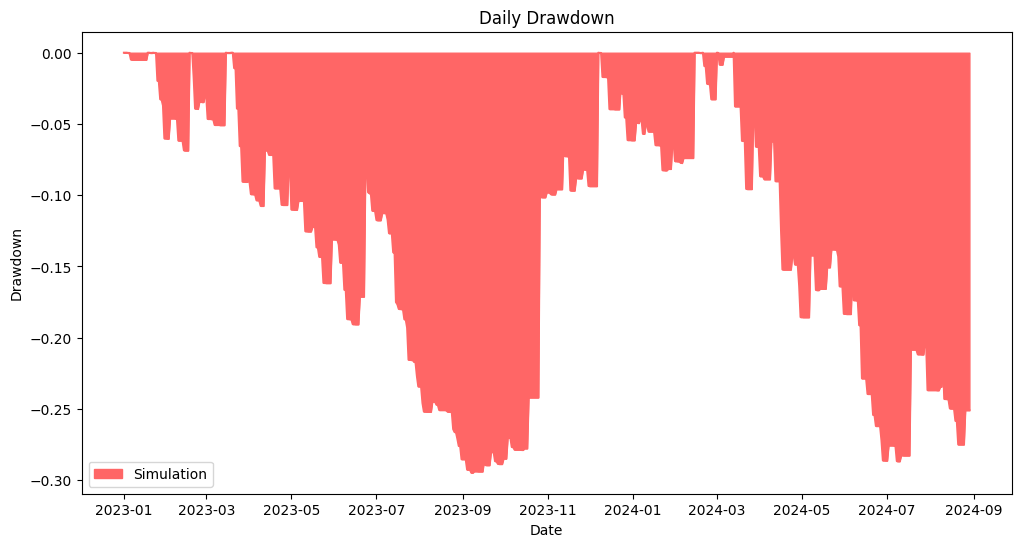

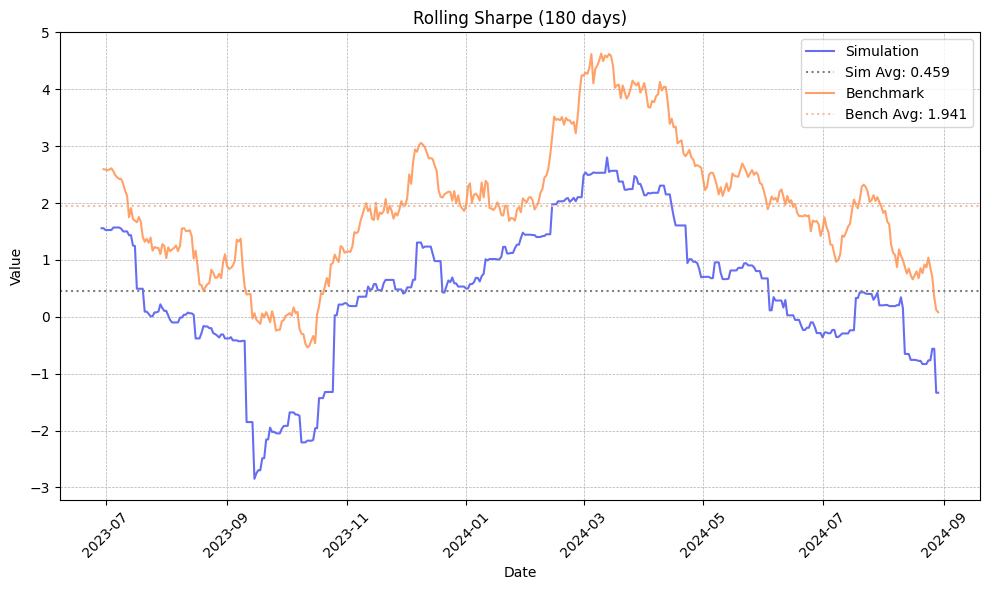

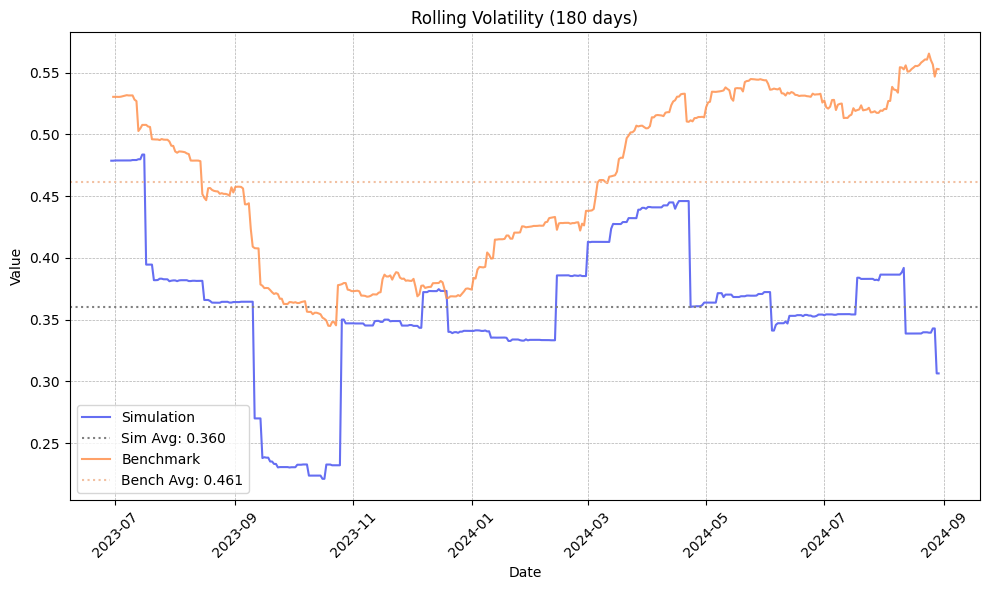

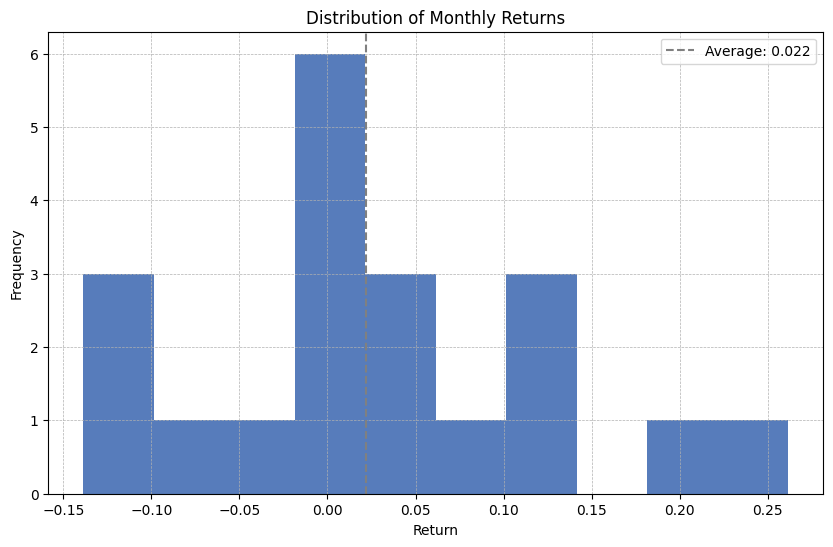

In [4]:
strategy = MyStrategy(
    data=backtest_data,
    benchmark=benchmark_data,
    initial_capital=100_000,
    commission_rate=0.0002,
    maint_margin_rate=0.005,
    maint_amount=50,
    slippage_model=Slippage.FixedPercent(f=0.001)
)
returns = strategy.run()
strategy.plot(returns)

#### You can also fetch the trade history for analysis.

In [5]:
strategy.fetch_trades()

,id,created_at,executed_at,symbol,qty,price,type,status,stop_price,is_triggered,reason,theoretical_price,executed_price,commission,pnl,realized_pnl,label
0,3a4d7380eca44248,2023-01-04 07:00:00,2023-01-04 07:00:00,BTC,5.0,16872.8,LIMIT,FILLED,None,False,None,16872.8,16889.6728,16.889673,0.0000,-16.889673,None
1,a07e2e1583794642,2023-01-06 02:00:00,2023-01-06 02:00:00,BTC,-5.0,NaN,MARKET,FILLED,None,False,None,16818.1,16801.2819,16.801282,-441.9545,-458.755782,None
2,4656f310015348a0,2023-01-07 01:00:00,2023-01-07 01:00:00,BTC,5.0,16969.9,LIMIT,FILLED,None,False,None,16969.9,16986.8699,16.986870,0.0000,-16.986870,None
3,4e076b588e564dc8,2023-01-18 19:00:00,2023-01-18 19:00:00,BTC,-5.0,NaN,MARKET,FILLED,None,False,None,20933.3,20912.3667,20.912367,19627.4840,19606.571633,None
4,8c3e7c39283f44ec,2023-01-20 08:00:00,2023-01-20 08:00:00,BTC,5.0,20954.1,LIMIT,FILLED,None,False,None,20954.1,20975.0541,20.975054,0.0000,-20.975054,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,6413bc52702c47bb,2024-08-21 08:00:00,2024-08-21 08:00:00,BTC,-2.0,NaN,MARKET,FILLED,None,False,None,59689.2,59629.5108,23.851804,-3040.7560,-3064.607804,None
360,946254548db24c42,2024-08-21 23:00:00,2024-08-21 23:00:00,BTC,2.0,61145.8,LIMIT,FILLED,None,False,None,61145.8,61206.9458,24.482778,0.0000,-24.482778,None
361,0fcd9e15028c4a93,2024-08-26 02:00:00,2024-08-26 02:00:00,BTC,-2.0,NaN,MARKET,FILLED,None,False,None,63893.3,63829.4067,25.531763,5244.9218,5219.390037,None
362,4886018f42f04f00,2024-08-26 03:00:00,2024-08-26 03:00:00,BTC,2.0,64033.0,LIMIT,FILLED,None,False,None,64033.0,64097.0330,25.638813,0.0000,-25.638813,None
